Import core numerical and utility functionality

In [1]:
import numpy as np
from numba import jit, njit, prange
import pandas as pd
import scipy.stats as stats
import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import logbook
from logbook import Logger, StreamHandler, FileHandler, DEBUG, INFO, WARNING, ERROR, NOTSET
from tqdm.notebook import tqdm

import os
import time
import sys

Setup

In [42]:
np.random.seed(42)

NAME = 'assignment1'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
LOG_PATH = f'log/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH, LOG_PATH]]

ANIM_BACKEND = 'ffmpeg'
LOAD_CACHED_FILES_IF_AVAILABLE = True

log = Logger(f'{NAME}_logger')
fh = FileHandler(f'{LOG_PATH}/log.log', mode='w', level=DEBUG, bubble=True)
fh.push_application()
sh = StreamHandler(sys.stdout, level=WARNING, bubble=True)
sh.push_application()

In [39]:
def plot_michaelis_menten(substrate_range, km, vmax, color='tab:blue'):
    v = vmax * substrate_range / (km + substrate_range)
    fig = plt.figure(figsize=(5, 4))
    plt.plot(substrate_range, v, color=color)
    plt.xlabel('Substrate concentration $[S]$')
    plt.ylim(0, vmax*1.05)
    plt.yticks([0, vmax/2, vmax], ['0', '$\\frac{V_{max}}{2}$', '$V_{{max}}$'])
    plt.ylabel('Reaction rate $v$')
    plt.title(f'Michaelis-Menten kinetics')
    plt.legend([f'$K_m={km}, V_{{max}}={vmax}$'])
    return fig

def plot_comparison_michaelis_menten(substrate_range, kms, vmaxs, colors):
    fig = plt.figure(figsize=(5, 4))
    for km, vmax, color in zip(kms, vmaxs, colors):
        v = vmax * substrate_range / (km + substrate_range)
        plt.plot(substrate_range, v, label=f'$K_m={km}, V_{{max}}={vmax}$', color=color)
    plt.xlabel('Substrate concentration $[S]$')
    plt.ylabel('Reaction rate $v$')
    plt.title(f'Michaelis-Menten kinetics')
    plt.legend()
    return fig

Visualize Michaelis-Menten kinetics using the corresponding equation

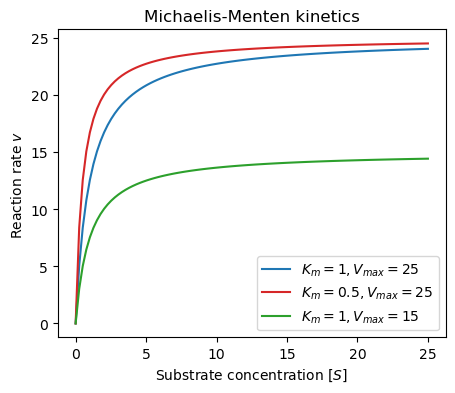

In [41]:
substrate = np.linspace(0, 25, 100)
kms = [1, 0.5, 1]
vmaxs = [25, 25, 15]
colors = ['tab:blue', 'tab:red', 'tab:green']
for km, vmax, color in zip(kms, vmaxs, colors):
    fig = plot_michaelis_menten(substrate, km, vmax, color=color)
    fig.savefig(f'{MEDIA_PATH}/michaelis_menten_km={km}_vmax={vmax}.png')
    plt.close(fig)
fig_comp = plot_comparison_michaelis_menten(substrate, kms, vmaxs, colors)
fig_comp.savefig(f'{MEDIA_PATH}/michaelis_menten_comparison.png')

In [ ]:
fh.close()
sh.close()